[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kaggle-runa/MameLand_vol3/blob/main/src/notebook/01_%E7%AB%B6%E9%A6%AC%E3%83%87%E3%83%BC%E3%82%BF%E5%8F%AF%E8%A6%96%E5%8C%96.ipynb)

In [ ]:
!pip install japanize_matplotlib

In [2]:
import numpy as np
import pandas as pd
import re
import io
import ipywidgets as widgets
from IPython.display import display
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import japanize_matplotlib

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

In [4]:
# google driveへのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


データはGoogle Driveの競馬分析/dataレポジトリにあることを想定しています。  
自分のフォルダ構成に応じてデータのパスを適宜変更して下さい。


- 競馬分析/
  - data/  # 分析に使う生データ
  - feature_data/  # 02_データの前処理.ipynbで作成した生データを加工したデータ
  - simulation_data/ # 05_馬券の購入シミュレーション(ワイド・複勝).ipynbで利用する回収率を計算するためのデータ
  - notebooks/  # 競馬分析を行うnotebook
    - 00_データのスクレイピング.ipynb
    - 01_競馬データ可視化.ipynb
    - 02_データの前処理.ipynb
    - 03_モデルの学習.ipynb
    - 04_新規データでの予測.ipynb
    - 05_馬券の購入シミュレーション(ワイド・複勝).ipynb
  - model/  # 作成したモデルを格納するレポジトリ

In [4]:
data = pd.read_csv('/content/drive/MyDrive/競馬分析/data/race_result.csv')
data.head(10)

,race_id,event_date,location,race_title,race_type,race_turn,course_len,weather,ground_condition,finish_position,frame_number,horse_number,horse_id,horse_name,sex_age,carried_weight,jockey_id,jockey,time,difference,odds,popularity,horse_weight,trainer
0,202206010101,2022-01-05,中山,3歳未勝利,ダ,右,1200,晴,良,1,8,15,2019103610,ニシノアナ,牝3,51.0,1192,横山琉人,1:12.5,NaN,6.8,4.0,456(+4),[東] 相沢郁
1,202206010101,2022-01-05,中山,3歳未勝利,ダ,右,1200,晴,良,2,5,10,2019100855,トラストパッキャオ,牝3,54.0,1179,菅原明良,1:12.5,クビ,57.2,12.0,458(+2),[東] 高木登
2,202206010101,2022-01-05,中山,3歳未勝利,ダ,右,1200,晴,良,3,2,4,2019103542,マイネルシトラス,牡3,56.0,1009,柴田大知,1:12.5,クビ,3.7,1.0,518(-2),[東] 武市康男
3,202206010101,2022-01-05,中山,3歳未勝利,ダ,右,1200,晴,良,4,1,2,2019104288,ピカリエ,牝3,54.0,1119,伊藤工真,1:12.8,1.1/2,16.0,9.0,486(+6),[東] 金成貴史
4,202206010101,2022-01-05,中山,3歳未勝利,ダ,右,1200,晴,良,5,8,16,2019101003,ブラッドライン,牡3,56.0,5212,Ｍ．デム,1:13.2,2.1/2,10.0,5.0,478(-2),[東] 伊藤大士
5,202206010101,2022-01-05,中山,3歳未勝利,ダ,右,1200,晴,良,6,4,8,2019101217,デザートサファリ,牡3,56.0,1091,丹内祐次,1:13.4,1,6.3,3.0,470(-4),[東] 岩戸孝樹
6,202206010101,2022-01-05,中山,3歳未勝利,ダ,右,1200,晴,良,7,5,9,2019101408,ニシノスーベニア,牡3,56.0,422,内田博幸,1:13.7,1.3/4,14.3,8.0,536(+28),[東] 上原博之
7,202206010101,2022-01-05,中山,3歳未勝利,ダ,右,1200,晴,良,8,6,11,2019102271,ペルペテュエル,牡3,56.0,5386,戸崎圭太,1:13.7,クビ,6.2,2.0,472(0),[東] 武藤善則
8,202206010101,2022-01-05,中山,3歳未勝利,ダ,右,1200,晴,良,9,4,7,2019104028,アイアムラベンダー,牝3,54.0,1085,松岡正海,1:13.9,3/4,10.7,6.0,462(-2),[東] 奥平雅士
9,202206010101,2022-01-05,中山,3歳未勝利,ダ,右,1200,晴,良,10,3,6,2019105170,オールフラッグ,牡3,56.0,1170,横山武史,1:13.9,クビ,12.6,7.0,478(+10),[東] 奥村武


## データの把握(探索的データ解析：EDA)

より良い機械学習モデルを構築する際には、特徴量エンジニアリング(Feature Engineering)を必要することが多々あり、その際に深いデータの知識と理解が求められます。(例 月曜には特定の商品売上が上がる→曜日と商品を条件にフラグ化する)
どのようなデータセットを扱っているのか、データの傾向がどのようになっているかなどを事前によく理解しておく必要があり、「探索的データ解析（EDA）」はまさしくそれを目的とした作業となります。
EDAには様々な手法がありますが、テーブルデータの場合、最低限以下は確認しておくことをオススメします。

・生データ  
・行数、列数、列名  
・データの型と欠損値  
・基本統計量  
・目的変数と説明変数間との相関係数  
・変数の分布

① 生データ

In [5]:
data.head()

,race_id,event_date,location,race_title,race_type,race_turn,course_len,weather,ground_condition,finish_position,frame_number,horse_number,horse_id,horse_name,sex_age,carried_weight,jockey_id,jockey,time,difference,odds,popularity,horse_weight,trainer
0,202206010101,2022-01-05,中山,3歳未勝利,ダ,右,1200,晴,良,1,8,15,2019103610,ニシノアナ,牝3,51.0,1192,横山琉人,1:12.5,NaN,6.8,4.0,456(+4),[東] 相沢郁
1,202206010101,2022-01-05,中山,3歳未勝利,ダ,右,1200,晴,良,2,5,10,2019100855,トラストパッキャオ,牝3,54.0,1179,菅原明良,1:12.5,クビ,57.2,12.0,458(+2),[東] 高木登
2,202206010101,2022-01-05,中山,3歳未勝利,ダ,右,1200,晴,良,3,2,4,2019103542,マイネルシトラス,牡3,56.0,1009,柴田大知,1:12.5,クビ,3.7,1.0,518(-2),[東] 武市康男
3,202206010101,2022-01-05,中山,3歳未勝利,ダ,右,1200,晴,良,4,1,2,2019104288,ピカリエ,牝3,54.0,1119,伊藤工真,1:12.8,1.1/2,16.0,9.0,486(+6),[東] 金成貴史
4,202206010101,2022-01-05,中山,3歳未勝利,ダ,右,1200,晴,良,5,8,16,2019101003,ブラッドライン,牡3,56.0,5212,Ｍ．デム,1:13.2,2.1/2,10.0,5.0,478(-2),[東] 伊藤大士


②EDA(行数、列数、列名)

In [6]:
# 行数・列数と列名を表示する関数
def queue_information(data):
    print('行数・列数の表示\n', data.shape)
    print('-'* 100)
    print('列名の表示\n', data.columns)

In [7]:
queue_information(data)

行数・列数の表示
 (132286, 24)
----------------------------------------------------------------------------------------------------
列名の表示
 Index(['race_id', 'event_date', 'location', 'race_title', 'race_type',
       'race_turn', 'course_len', 'weather', 'ground_condition',
       'finish_position', 'frame_number', 'horse_number', 'horse_id',
       'horse_name', 'sex_age', 'carried_weight', 'jockey_id', 'jockey',
       'time', 'difference', 'odds', 'popularity', 'horse_weight', 'trainer'],
      dtype='object')


③EDA(データの型と欠損値)

In [8]:
# 列毎の欠損値の数とデータ型を表示
# int:数値型 float:小数点型 object:文字列型

def missing_and_types(data):
    print('列ごと欠損値の数の表示\n', data.isnull().sum())
    print('-'* 100)
    print('データの型の表示\n', data.info())

In [9]:
missing_and_types(data)

列ごと欠損値の数の表示
 race_id                 0
event_date              0
location                0
race_title              0
race_type               0
race_turn               0
course_len              0
weather                 0
ground_condition        0
finish_position         0
frame_number            0
horse_number            0
horse_id                0
horse_name              0
sex_age                 0
carried_weight          0
jockey_id               0
jockey                  0
time                 1130
difference          10787
odds                    0
popularity            507
horse_weight            0
trainer                 0
dtype: int64
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132286 entries, 0 to 132285
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   race_id           132286 non-null  in

④EDA(基本統計量)
- describe()でデータの基本統計量を確認できます

In [10]:
data.describe()

,race_id,course_len,frame_number,horse_number,horse_id,carried_weight,jockey_id,popularity
count,1.322860e+05,132286.000000,132286.000000,132286.000000,1.322860e+05,132286.000000,132286.000000,131779.000000
mean,2.022987e+11,1655.740139,4.769726,7.646886,2.019387e+09,55.309984,1432.279289,7.621730
std,7.961049e+07,418.452933,2.270749,4.378694,1.521088e+06,1.922988,1157.446608,4.365115
min,2.022010e+11,1000.000000,1.000000,1.000000,2.011101e+09,48.000000,422.000000,1.000000
25%,2.022071e+11,1400.000000,3.000000,4.000000,2.018110e+09,54.000000,1092.000000,4.000000
50%,2.023051e+11,1600.000000,5.000000,7.000000,2.019107e+09,55.000000,1154.000000,7.000000
75%,2.024020e+11,1800.000000,7.000000,11.000000,2.020107e+09,57.000000,1185.000000,11.000000
max,2.024100e+11,4250.000000,8.000000,18.000000,2.022110e+09,65.000000,5664.000000,18.000000


⑤EDA(目的変数と説明変数間との相関係数)      
corr()で相関係数を確認できます。   
下記の引数を設定することでそれぞれの相関係数を確認できます
- 'pearson': ピアソンの積率相関係数（デフォルト）
- 'kendall': ケンドールの順位相関係数
- 'spearman': スピアマンの順位相関係数

In [11]:
# レース除外された馬などをここで一旦999に設定しておく
data['finish_position'] = (data['finish_position'] .replace('中', 999) .replace('除', 999) .replace('取', 999) .replace(r'(\d+)\(降\)', r'\1', regex=True) .astype(float))

# 枠番・馬番・斤量・人気・着順の相関を取る
data_corr = data[["frame_number", "horse_number", "carried_weight", "popularity", "finish_position"]].corr()
data_corr

,frame_number,horse_number,carried_weight,popularity,finish_position
frame_number,1.000000,0.909655,0.008061,-0.013861,0.001922
horse_number,0.909655,1.000000,-0.027399,0.088329,0.000206
carried_weight,0.008061,-0.027399,1.000000,-0.098265,0.034923
popularity,-0.013861,0.088329,-0.098265,1.000000,0.045296
finish_position,0.001922,0.000206,0.034923,0.045296,1.000000


⑥EDA(変数の分布の確認)  
特に分類問題の場合、目的変数のラベルの不均衡具合などを確認しておくことをオススメします。どれかのカテゴリーに偏っている場合(不均衡データ)はそれを考慮する必要があるため

In [12]:
# 目的変数の作成(3着以内に入る馬を予測する)
data['target'] = (data['finish_position'] <= 3).astype(int)

target
0    103300
1     28986
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------


/var/folders/f2/dyf3ym2n7kgb2_9yskmdtj0jr9qsrg/T/ipykernel_77506/612751759.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['target'],kde=False, rug=False)


<Axes: xlabel='target'>

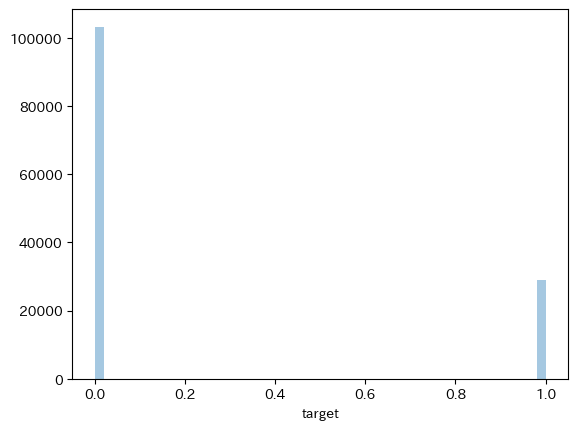

In [13]:
# 目的変数のそれぞれのラベル数を表示
print(data['target'].value_counts())
print('-'*100)
# 目的変数のヒストグラムの表示
sns.distplot(data['target'],kde=False, rug=False)

簡単にデータの傾向を見ましたのでより深掘りしてデータを見ていきましょう！

まずは騎手年別の勝率・連帯率(２着以内に入る確率)・複勝率(3着以内に入る確率)を算出します

In [14]:
# event_dateから年を抽出
data['year'] = data['event_date'].str[:4]

# 各特徴量とfinishi_positonの関係を表示するためのデータを作成
result = data.groupby(['year', 'jockey'])['finish_position'].agg(
    total_races='count',
    first_place_count=lambda x: (x == 1).sum(),
    top2_count=lambda x: (x <= 2).sum(),
    top3_count=lambda x: (x <= 3).sum()
).reset_index()

# 確率を計算
result['first_place_prob'] = result['first_place_count'] / result['total_races']
result['top2_prob'] = result['top2_count'] / result['total_races']
result['top3_prob'] = result['top3_count'] / result['total_races']

# 結果を表示
result

,year,jockey,total_races,first_place_count,top2_count,top3_count,first_place_prob,top2_prob,top3_prob
0,2022,イーガン,59,9,15,21,0.152542,0.254237,0.355932
1,2022,ウィリア,9,0,2,3,0.000000,0.222222,0.333333
2,2022,ギュイヨ,10,2,2,2,0.200000,0.200000,0.200000
3,2022,グラハム,4,0,0,0,0.000000,0.000000,0.000000
4,2022,ドイル,108,2,11,18,0.018519,0.101852,0.166667
...,...,...,...,...,...,...,...,...,...
572,2024,鮫島良太,72,1,5,8,0.013889,0.069444,0.111111
573,2024,鷲頭虎太,165,1,10,20,0.006061,0.060606,0.121212
574,2024,黒岩悠,52,5,7,9,0.096154,0.134615,0.173077
575,2024,黛弘人,300,9,22,35,0.030000,0.073333,0.116667


ipywidgetsというライブラリを使うことでインタラクティブにデータを確認することができます。

In [15]:
# 年フィルタ用のドロップダウンウィジェットを作成
year_dropdown = widgets.Dropdown(
    options=["すべて"] + sorted(result['year'].unique().tolist()),
    value="すべて",
    description='Year:',
)

# 騎手フィルタ用のドロップダウンウィジェットを作成
jockey_dropdown = widgets.Dropdown(
    options=["すべて"] + sorted(result['jockey'].unique().tolist()),
    value="すべて",
    description='騎手:',
)

# 並び替え用のドロップダウンウィジェットを作成
sort_by_dropdown = widgets.Dropdown(
    options=["なし"] + ["total_races", "first_place_count", "top2_count", "top3_count", "first_place_prob", "top2_prob", "top3_prob"],
    value="なし",
    description='並び替え条件:',
)

# 昇順・降順を選択するトグルボタン
ascending_toggle = widgets.ToggleButtons(
    options=['Ascending', 'Descending'],
    description='Order:',
    disabled=False,
    button_style=''
)

# フィルタリングと並び替えされたデータを表示するための関数
def filter_and_sort_data(year, jockey, sort_by, order):
    filtered_df = result
    if year != "すべて":
        filtered_df = filtered_df[filtered_df['year'] == year]
    if jockey != "すべて":
        filtered_df = filtered_df[filtered_df['jockey'] == jockey]

    if sort_by != "なし":
        ascending = True if order == 'Ascending' else False
        filtered_df = filtered_df.sort_values(by=sort_by, ascending=ascending)

    display(filtered_df)

# interact関数でウィジェットとフィルタリング・並び替え関数を連動させる
widgets.interact(filter_and_sort_data,
                 year=year_dropdown,
                 jockey=jockey_dropdown,
                 sort_by=sort_by_dropdown,
                 order=ascending_toggle)

interactive(children=(Dropdown(description='Year:', options=('すべて', '2022', '2023', '2024'), value='すべて'), Dro…

<function __main__.filter_and_sort_data(year, jockey, sort_by, order)>

より詳しい条件で馬券内に入る確率を確認してみます。

In [16]:
df = data.copy()

df['finish_within_1'] = df['finish_position'] == 1
df['finish_within_2'] = df['finish_position'] <= 2
df['finish_within_3'] = df['finish_position'] <= 3

# 確率の計算
total_races = df.shape[0]
finish_within_1_count = df['finish_within_1'].sum()
prob_finish_within_1 = finish_within_1_count / total_races

finish_within_2_count = df['finish_within_2'].sum()
prob_finish_within_2 = finish_within_2_count / total_races

finish_within_3_count = df['finish_within_3'].sum()
prob_finish_within_3 = finish_within_3_count / total_races

In [17]:
# 年フィルタ用のドロップダウンウィジェットを作成
year_dropdown = widgets.Dropdown(
    options=["すべて"] + sorted(result['year'].unique().tolist()),
    value="すべて",
    description='Year:',
)

# locationフィルタ用のドロップダウンウィジェットを作成
location_dropdown = widgets.Dropdown(
    options=["すべて"] + sorted(df['location'].unique().tolist()),
    value="すべて",
    description='競馬場:',
)

# race_typeフィルタ用のドロップダウンウィジェットを作成
race_type_dropdown = widgets.Dropdown(
    options=["すべて"] + sorted(df['race_type'].unique().tolist()),
    value="すべて",
    description='レース種別:',
)

# course_lenフィルタ用のドロップダウンウィジェットを作成
course_len_dropdown = widgets.Dropdown(
    options=["すべて"] + sorted(df['course_len'].unique().tolist()),
    value="すべて",
    description='レースの距離:',
)

# jockeyフィルタ用のドロップダウンウィジェットを作成
jockey_dropdown = widgets.Dropdown(
    options=["すべて"] + sorted(df['jockey'].unique().tolist()),
    value="すべて",
    description='騎手:',
)

# popularityフィルタ用のドロップダウンウィジェットを作成
popularity_dropdown = widgets.Dropdown(
    options=["すべて"] + sorted(df['popularity'].unique().tolist()),
    value="すべて",
    description='人気順:',
)

# フィルタリングされたデータを表示するための関数
def filter_data(year, location, race_type, course_len, jockey, popularity):
    filtered_df = df
    if year != "すべて":
        filtered_df = filtered_df[filtered_df['year'] == year]
    if location != "すべて":
        filtered_df = filtered_df[filtered_df['location'] == location]
    if race_type != "すべて":
        filtered_df = filtered_df[filtered_df['race_type'] == race_type]
    if course_len != "すべて":
        filtered_df = filtered_df[filtered_df['course_len'] == course_len]
    if jockey != "すべて":
        filtered_df = filtered_df[filtered_df['jockey'] == jockey]
    if popularity != "すべて":
        filtered_df = filtered_df[filtered_df['popularity'] == popularity]

    display(filtered_df[["event_date", "location", "race_type", "course_len", "jockey", "popularity"]])
    # finish_positionが3以内になる確率を計算
    if filtered_df.shape[0] > 0:
        prob_finish_within_1 = filtered_df['finish_within_1'].sum() / filtered_df.shape[0]
        prob_finish_within_2 = filtered_df['finish_within_2'].sum() / filtered_df.shape[0]
        prob_finish_within_3 = filtered_df['finish_within_3'].sum() / filtered_df.shape[0]
        print(f'1着になる確率: {prob_finish_within_1:.2%}')
        print(f'2着以内になる確率: {prob_finish_within_2:.2%}')
        print(f'3着以内になる確率: {prob_finish_within_3:.2%}')
    else:
        print('No data available for the selected filters.')

# interact関数でウィジェットとフィルタリング関数を連動させる
widgets.interact(filter_data,
                 year=year_dropdown,
                 location=location_dropdown,
                 race_type=race_type_dropdown,
                 course_len=course_len_dropdown,
                 jockey=jockey_dropdown,
                 popularity=popularity_dropdown)

interactive(children=(Dropdown(description='Year:', options=('すべて', '2022', '2023', '2024'), value='すべて'), Dro…

<function __main__.filter_data(year, location, race_type, course_len, jockey, popularity)>